# Fig 3, Fig S6 Plotting

This notebook plots out the data associated with Figure 3 and Figure S6.

### Standard Imports

In [7]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import matplotlib as mpl
from cycler import cycler
import pylab

# Plotting parameters
sns.set_context("talk", font_scale=1, rc={"lines.linewidth": 2.0, 'lines.markersize': 5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))
mpl.rc('text', usetex=False)
tw = 1.5
sns.set_style({"xtick.major.size": 12, "ytick.major.size": 12,
               "xtick.minor.size": 8, "ytick.minor.size": 8,
               'axes.labelsize': 48,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})
mpl.rc('xtick', labelsize=24) 
mpl.rc('ytick', labelsize=24)
mpl.rc('axes', linewidth=1.75)
plt.gcf().subplots_adjust(bottom=0.15)
sns.set_style({'axes.labelsize': 48, 'axes.titlesize': 48})
cm = 1/2.54


# Color variables
cb_green = (102/255, 194/255, 165/255, 0.5)
cb_orange = (252/255, 141/255, 98/255, 0.5)
cb_blue = (141/255, 160/255, 203/255, 0.5)
cb_darkblue = (141/255, 160/255, 203/255, 0.25)
alpha_grey = (215/255, 215/255, 215/255, 1.0)
very_alpha_blue = (.75, .75, 1)

%matplotlib inline

### Import Data

In [2]:
df = pd.read_excel('./data/CFU_counts.xlsx', sheet_name='Fig 3')

### Plot raw CFU counts

<Figure size 283.465x113.386 with 0 Axes>

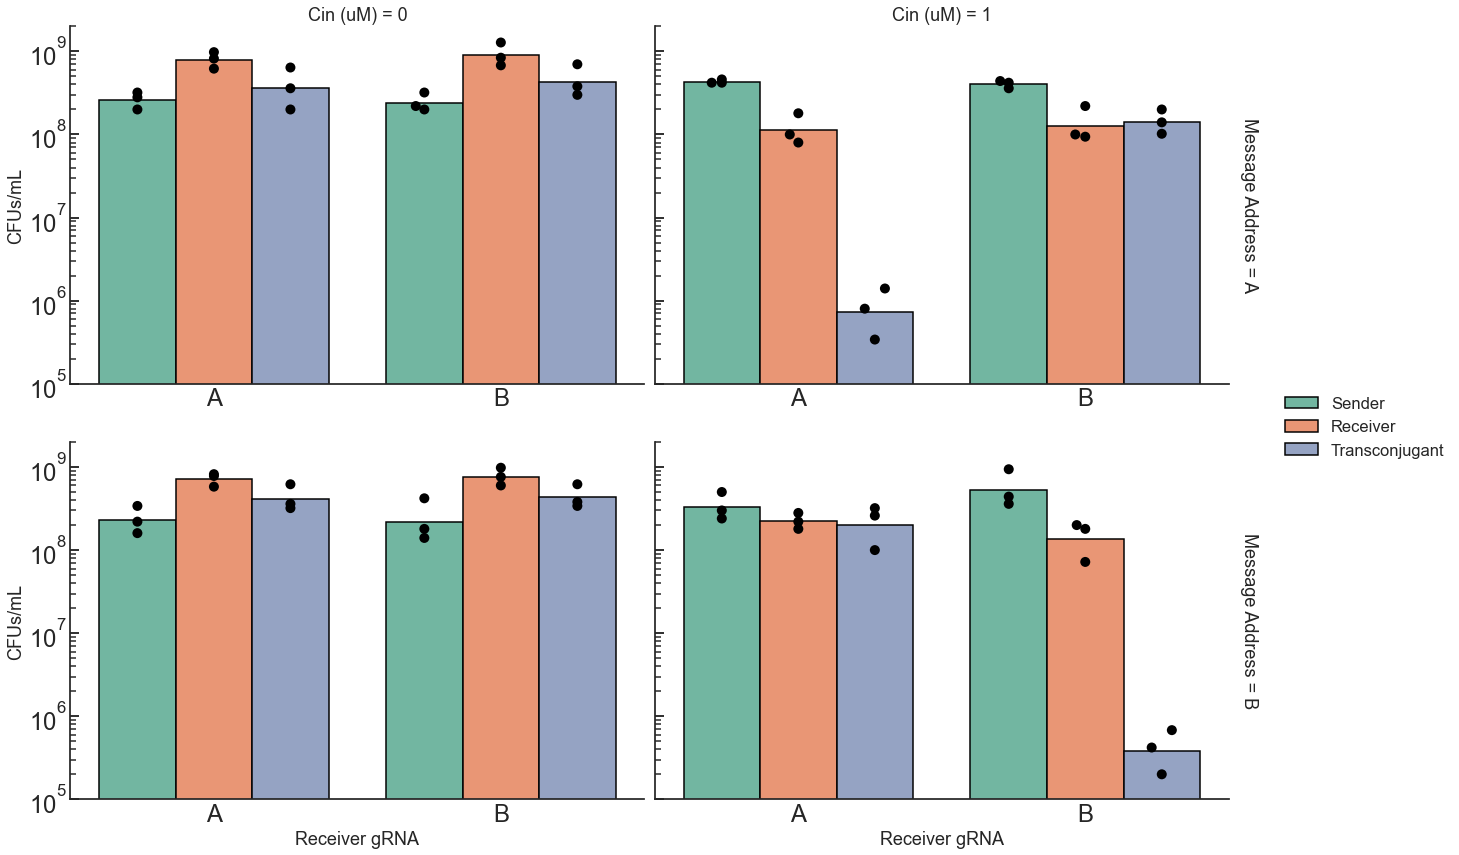

In [3]:
plt.figure(figsize=(10*cm,4*cm))
g = sns.FacetGrid(df, col='Cin (uM)', row='Message Address',
                  sharex=False, sharey=True, margin_titles=True,
                  aspect=1.5, height=6 )

alpha_val = 0.5
alpha_red = (alpha_val + 1/2, alpha_val, alpha_val)
alpha_black = (alpha_val, alpha_val, alpha_val)
alpha_blue = (alpha_val, alpha_val, alpha_val + 1/2)

cb_green = (102/255, 194/255, 165/255, 0.5)
cb_orange = (252/255, 141/255, 98/255, 0.5)
cb_blue = (141/255, 160/255, 203/255, 0.5)

g.map(sns.barplot, 'Receiver gRNA', 'CFUs/mL', 'Strain',
      palette=[cb_green, cb_orange, cb_blue], alpha=None,
      errcolor='k', edgecolor='k',
      ci=None, estimator=stats.mstats.gmean,
      order=['A','B'],
      hue_order=['Sender', 'Receiver', 'Transconjugant'])
g.map(sns.swarmplot, 'Receiver gRNA', 'CFUs/mL', 'Strain',
      palette=['k'], edgecolor='k', s=10, dodge=True,
      order=['A','B'], hue_order=['Sender','Receiver','Transconjugant']
     )

g.set(yscale='log',
      ylim=(1e5, 2e9)
     )
g.add_legend()

plt.savefig('./figs/Fig_3B.pdf', 
            bbox_inches='tight'
           )

plt.show()

### Calculate Transfer Rates

Calculate $T/(S*R)$ from the above data for each condition, where $T$ is the transconjugant density, $S$ is the sender density, and $R$ is the total receiver density. Also calculate the geometric mean transfer rate of the three replicates for each condition.

In [4]:
# Get transfer rates
rate_df = pd.DataFrame(columns=[
                                'Message Address',
                                'Receiver gRNA',
                                'Cin (uM)',
                                'Transfer Rate',
                                'Geomean Transfer Rate',
                                ])

reps = [1,2,3]
sites = ['A', 'B']
cins = [0, 1]

for a in range(len(sites)):
    for s in range(len(sites)):
        for c in range(len(cins)):
            rates = np.empty(len(reps))
            for r in range(len(reps)):
                address = sites[a]
                rep = reps[r]
                site = sites[s]
                cin = cins[c]

                S = df[(df['Replicate'] == rep) &
                       (df['Message Address'] == address) &
                       (df['Receiver gRNA'] == site) &
                       (df['Cin (uM)'] == cin) &
                       (df['Strain'] == 'Sender')]['CFUs/mL'].values
                R = df[(df['Replicate'] == rep) &
                       (df['Message Address'] == address) &
                       (df['Receiver gRNA'] == site) &
                       (df['Cin (uM)'] == cin) &
                       (df['Strain'] == 'Receiver')]['CFUs/mL'].values
                T = df[(df['Replicate'] == rep) &
                       (df['Message Address'] == address) &
                       (df['Receiver gRNA'] == site) &
                       (df['Cin (uM)'] == cin) &
                       (df['Strain'] == 'Transconjugant')]['CFUs/mL'].values

                assert len(S) == 1
                assert len(R) == 1
                assert len(T) == 1

                S = S[0]
                R = R[0]
                T = T[0]

                rate = T/(S*R)

                rates[r] = rate

                if r != len(reps)-1:
                    tempdict = pd.DataFrame({'Replicate': rep,
                                'Message Address': address,
                                'Receiver gRNA': site,
                                'Cin (uM)': cin,
                                'Transfer Rate': rate}, index=[0])

                    rate_df = pd.concat([rate_df, tempdict], ignore_index=True)
                else:
                    tempdict = pd.DataFrame({'Replicate': rep,
                                'Message Address': address,
                                'Receiver gRNA': site,
                                'Cin (uM)': cin,
                                'Transfer Rate': rate,
                                'Geomean Transfer Rate': stats.mstats.gmean(rates)
                               }, index=[0])
                    
                    rate_df = pd.concat([rate_df, tempdict], ignore_index=True)
                    

<Figure size 113.386x113.386 with 0 Axes>

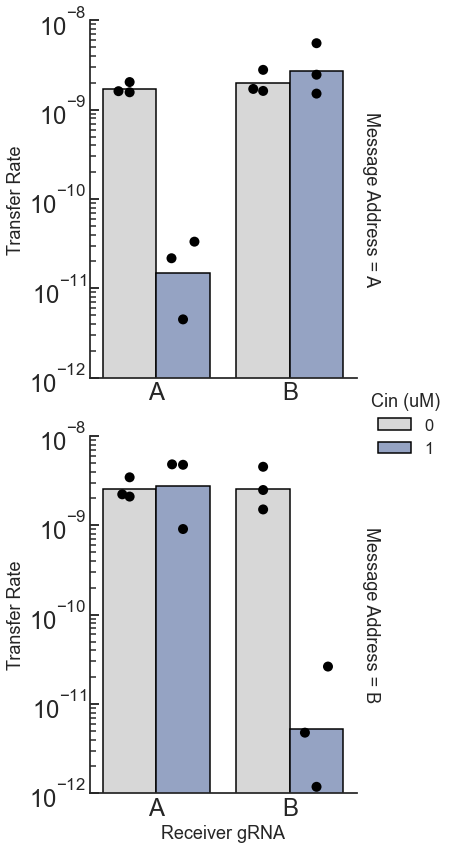

In [5]:
# Plot transfer rates

plt.figure(figsize=(4*cm,4*cm))
g = sns.FacetGrid(rate_df, row='Message Address',
                  sharex=False, sharey=True, margin_titles=True,
                  aspect=.8, 
                  height=6,
                 )

g.map(sns.barplot, 'Receiver gRNA', 'Geomean Transfer Rate', 'Cin (uM)',
      palette=[alpha_grey, cb_darkblue], alpha=None, ci=None, edgecolor='k',
      order=['A','B'], hue_order=[0,1],
     )
g.map(sns.swarmplot, 'Receiver gRNA', 'Transfer Rate', 'Cin (uM)',
      palette=['k'], edgecolor='k', s=10, dodge=True,
      order=['A','B'], hue_order=[0,1],
     )

g.set(yscale='log',
      ylim=(1e-12, 1e-8)
     )

g.add_legend(title='Cin (uM)')

plt.savefig('./figs/Fig_3C.pdf', bbox_inches='tight')

plt.show()

### Calculate fold change in transfer rates across different conditions

In [13]:
# Extract geometric mean transfer rate for each condition 
AA1 = rate_df[(rate_df['Message Address'] == 'A') &
                (rate_df['Receiver gRNA'] == 'A') &
                (rate_df['Cin (uM)'] == 1) &
                (rate_df['Replicate'] == 3)
               ]['Geomean Transfer Rate'].values[0]
AB1 = rate_df[(rate_df['Message Address'] == 'A') &
                (rate_df['Receiver gRNA'] == 'B') &
                (rate_df['Cin (uM)'] == 1) &
                (rate_df['Replicate'] == 3)
               ]['Geomean Transfer Rate'].values[0]
BA1 = rate_df[(rate_df['Message Address'] == 'B') &
                (rate_df['Receiver gRNA'] == 'A') &
                (rate_df['Cin (uM)'] == 1) &
                (rate_df['Replicate'] == 3)
               ]['Geomean Transfer Rate'].values[0]
BB1 = rate_df[(rate_df['Message Address'] == 'B') &
                (rate_df['Receiver gRNA'] == 'B') &
                (rate_df['Cin (uM)'] == 1) &
                (rate_df['Replicate'] == 3)
               ]['Geomean Transfer Rate'].values[0]

AA0 = rate_df[(rate_df['Message Address'] == 'A') &
                (rate_df['Receiver gRNA'] == 'A') &
                (rate_df['Cin (uM)'] == 0) &
                (rate_df['Replicate'] == 3)
               ]['Geomean Transfer Rate'].values[0]
AB0 = rate_df[(rate_df['Message Address'] == 'A') &
                (rate_df['Receiver gRNA'] == 'B') &
                (rate_df['Cin (uM)'] == 0) &
                (rate_df['Replicate'] == 3)
               ]['Geomean Transfer Rate'].values[0]
BA0 = rate_df[(rate_df['Message Address'] == 'B') &
                (rate_df['Receiver gRNA'] == 'A') &
                (rate_df['Cin (uM)'] == 0) &
                (rate_df['Replicate'] == 3)
               ]['Geomean Transfer Rate'].values[0]
BB0 = rate_df[(rate_df['Message Address'] == 'B') &
                (rate_df['Receiver gRNA'] == 'B') &
                (rate_df['Cin (uM)'] == 0) &
                (rate_df['Replicate'] == 3)
               ]['Geomean Transfer Rate'].values[0]

print('When Cas9 blocking was activated...')
print(f'The A message was biased towards its programmed recipient by {AB1/AA1}-fold.')
print(f'The B message was biased towards its programmed recipient by {BA1/BB1}-fold.')
print('\nWhen Cas9 blocking was not activated...')
print(f'The fold change in transfer rates between recipients for the A message was {AB0/AA0}-fold.')
print(f'The fold change in transfer rates between recipients for the B message was {BB0/BA0}-fold.')

When Cas9 blocking was activated...
The A message was biased towards its programmed recipient by 185.37096977331447-fold.
The B message was biased towards its programmed recipient by 520.2744265147783-fold.

When Cas9 blocking was not activated...
The fold change in transfer rates between recipients for the A message was 1.1452133627298053-fold.
The fold change in transfer rates between recipients for the b message was 1.0172845250771785-fold.


### Calculate receiver penetrance values for Fig S6

Receiver penetrance, or fractional receiver conversion, is defined as $T/R$ and in principle takes a value between 0 and 1.

In [6]:
# Get penetrance values

penetrance_df = pd.DataFrame(columns=[
                                'Message Address',
                                'Receiver gRNA',
                                'Cin (uM)',
                                'Penetrance',
                                'Geomean Penetrance',
                                ])

reps = [1,2,3]
sites = ['A', 'B']
cins = [0, 1]

for a in range(len(sites)):
    for s in range(len(sites)):
        for c in range(len(cins)):
            pens = np.empty(len(reps))
            for r in range(len(reps)):
                address = sites[a]
                rep = reps[r]
                site = sites[s]
                cin = cins[c]

                S = df[(df['Replicate'] == rep) &
                       (df['Message Address'] == address) &
                       (df['Receiver gRNA'] == site) &
                       (df['Cin (uM)'] == cin) &
                       (df['Strain'] == 'Sender')]['CFUs/mL'].values
                R = df[(df['Replicate'] == rep) &
                       (df['Message Address'] == address) &
                       (df['Receiver gRNA'] == site) &
                       (df['Cin (uM)'] == cin) &
                       (df['Strain'] == 'Receiver')]['CFUs/mL'].values
                T = df[(df['Replicate'] == rep) &
                       (df['Message Address'] == address) &
                       (df['Receiver gRNA'] == site) &
                       (df['Cin (uM)'] == cin) &
                       (df['Strain'] == 'Transconjugant')]['CFUs/mL'].values

                assert len(S) == 1
                assert len(R) == 1
                assert len(T) == 1

                S = S[0]
                R = R[0]
                T = T[0]

                pen = T/R

                pens[r] = pen

                if r != len(reps)-1:
                    tempdict_pen = pd.DataFrame({'Replicate': rep,
                                'Message Address': address,
                                'Receiver gRNA': site,
                                'Cin (uM)': cin,
                                'Penetrance': pen},
                                                index=[0])

                    penetrance_df = pd.concat([penetrance_df, tempdict_pen],
                                              ignore_index=True)
                    
                else:
                    tempdict_pen = pd.DataFrame({'Replicate': rep,
                                'Message Address': address,
                                'Receiver gRNA': site,
                                'Cin (uM)': cin,
                                'Penetrance': pen,
                                'Geomean Penetrance': stats.mstats.gmean(pens)},
                                                index=[0])

                    penetrance_df = pd.concat([penetrance_df, tempdict_pen],
                                              ignore_index=True)
                    



### Plot receiver penetrance for no-block condition

<Figure size 1440x576 with 0 Axes>

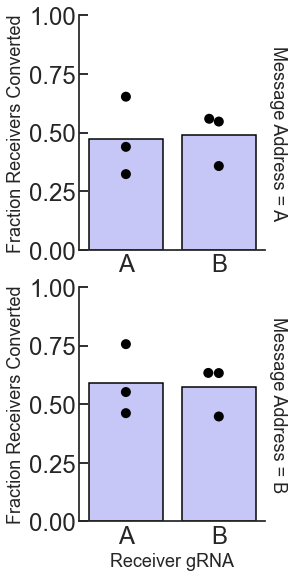

In [11]:
plt.figure(figsize=(20,8))
g = sns.FacetGrid(penetrance_df[penetrance_df['Cin (uM)'] == 0], row='Message Address',
                  sharex=False, sharey=True, margin_titles=True,
                  aspect=1.0, height=4,)

g.map(sns.barplot, 'Receiver gRNA', 'Penetrance',
      palette=[very_alpha_blue], ci=None, edgecolor='k',
      order=['A','B']
     )
g.map(sns.swarmplot, 'Receiver gRNA', 'Penetrance',
      palette=['k'], edgecolor='k', s=10, dodge=True,
      order=['A','B']
     )

g.set(ylim=(0,1.0))
g.set(ylabel='Fraction Receivers Converted')

plt.savefig('./figs/Fig_S6.pdf', bbox_inches='tight')

plt.show()

### Calculate average receiver penetrance in the no-block condition

In [18]:
mean_penetrance = np.mean(penetrance_df[penetrance_df['Cin (uM)'] == 0]['Penetrance'].values)

print(f'The mean fractional receiver conversion across the four conditions above was {mean_penetrance}.')

The mean fractional receiver conversion across the four conditions above was 0.5300185518754309.
